# Stereovision

![Suzanne](main.png)

Stereovision is a discipline that deals with the reconstruction of 3D information from images. For the reconstruction of a point, several images of this point are needed. These images must be taken from different points of view. The key step of the reconstruction, which is often problematic, is to identify the images of the point to be reconstructed in each view.

## Epipolar Geometry

Epipolar geometry involves two cameras. The epipolar geometry describes the geometric properties between two views of the same scene and depends only on the intrinsic parameters of the cameras and their relative positions. It provides, in particular, the epipolar constraint, which will be very useful to produce the matches between views.

## The Fondamental Matrix

![Epipolar Geometry - Sanyam Kapoor](epipolar.png)

Let us imagine that we have two images, right and left, of the world space. Let's take a point $\vec{x}$ in the right image space. The point $\vec{X}$ of the world space, of which $\vec{x}$ is the image, can be anywhere on the line passing through $\vec{x}$ and the optical center of the right camera. We will call this line the back-projected ray of $\vec{x}$. Let us note $\vec{x}'$ the image of $\vec{X}$ in the left image space. The locus of $\vec{x}'$ is therefore the image line of the back-projected ray of $\vec{x}$. This line is called the epipolar line and is denoted $\vec{l}'$. The epipolar line passes through the epipole $\vec{e}'$, image of the optical center of the right camera.

In 2D projective geometry, a line with equation $ax+by+c = 0$ is represented by a vector with three components $(a, b, c)^T$ defined to within one factor. Thus, we have the following relationship:

>The point $\vec{x}$ belongs to the line $\vec{l}$ if and only if $x^T\vec{l} = 0$.

Moreover, in 2D projective geometry, the following remarkable relations are valid:

- The intersection of two lines $l$ and $l'$ is given by $x = l \times l'$,
- The line passing through two points $x$ and $x'$ is given by $l = x \times x'$.

Note that the vector product can be written as a product of matrix $x \times y = [x]_\times y$ where

$$[x]_\times = \begin{pmatrix} 0 & −x3 & x2 \\ x3 & 0 & −x1 \\ −x2 & x1 & 0 \end{pmatrix}$$

To find the equation of the epipolar line in the left image space, we just need to find the coordinates of two points of this line. The first is the image $P'\vec{C}$ of the optical center $\vec{C}$ of the right camera where $P'$ is the projection matrix of the left camera. The second is $P'P^{+}\vec{x}$ where $P^{+}$ is the pseudo inverse of the projection matrix $P$ of the right camera. The epipolar line thus has the equation $l' = [P'\vec{C}]_\times{}P'P^{+}\vec{x} = F\vec{x}$ with $F = [P'\vec{C}]_\times{}P'P^{+}$. $F$ is called fundamental matrix.

Since the epipolar line $\vec{l}' = F\vec{x}$ is the locus of $\vec{x}'$, $\vec{x}'$ therefore belongs to $\vec{l}'$ which leads to the epipolar constraint :

>**The fundamental matrix is such that for any pair of points corresponding $\vec{x} \leftrightarrow \vec{x}'$ in the two images, we have $\vec{x}'^{T}F\vec{x} = 0$.**

## Computation of the fundamental matrix

The fundamental matrix $F$ has seven degrees of freedom. It has nine components but these are defined to within one scale factor, which removes one degree of freedom. Moreover, the matrix $F$ is a singular matrix ($det(F) = 0$) which gives us seven degrees of freedom. So we need at least seven correspondences to compute $F$. The equation $x'^{T}_iFx_i = 0$ and the seven correspondences allow us to write a system of equations of the form $Af = 0$, where $f$ is the vector which contains the components of the matrix $F$. Let us assume that $A$ is a 7×9 matrix of rank 7. The general solution of $Af = 0$ can be written $\alpha f_1 + (1-\alpha) f_2$ where $f_1$ and $f_2$ are two particular independent solutions of $Af = 0$. We then use the singularity constraint $det(\alpha F_1 + (1 - \alpha)F_2) = 0$ to determine $\alpha$. Since the singularity constraint gives rise to a third degree equation, we may have one or three solutions for $F$.

## OpenCV

In practice you will use the OpenCV library. In python, you have access to its functions through the `cv2` module.

You can find help with the calibration and reconstruction functions on the site https://docs.opencv.org/4.0.0/d9/d0c/group__calib3d.html

## Goal

In the zip of the statement you will find two sequences of images taken by two cameras during the scanning of an object by a laser plane.

![Laser](scanRight/scan0010.png)

You will also find shots of a checkerboard in different positions that will help you calibrate your cameras.

![Damier](chessboards/c2Right.png)

The goal is to reconstruct the scanned object in 3D.

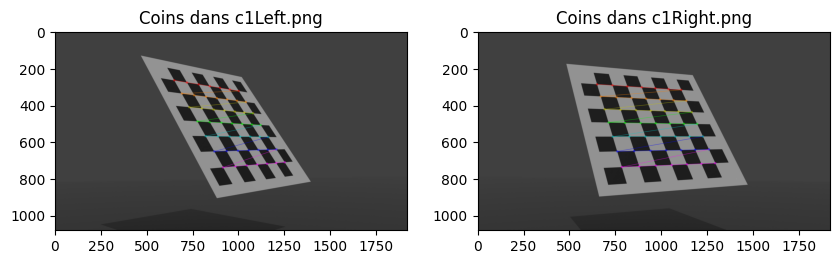

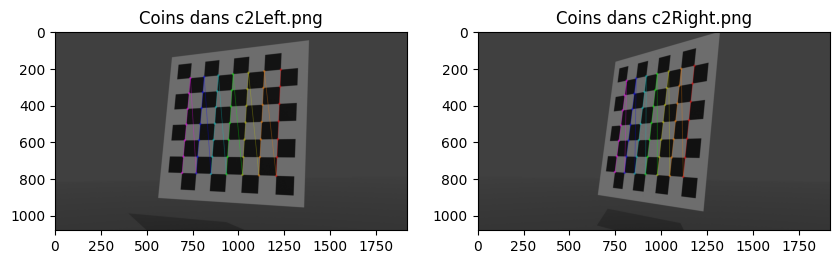

Damier NON détecté pour c3Left.png / c3Right.png


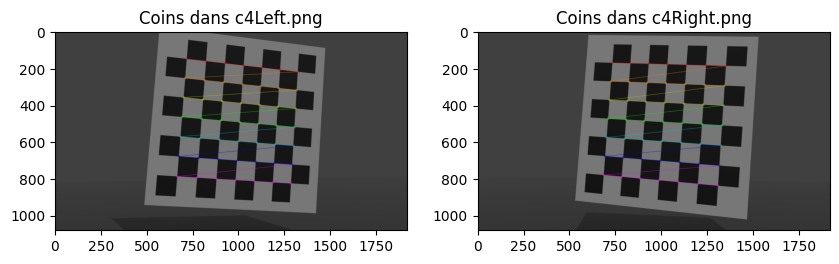

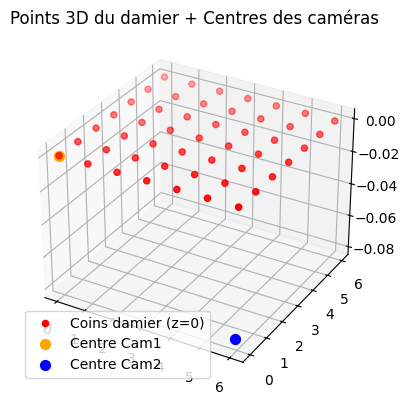

In [1]:
import cv2 as cv
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# --------------------------------------------------------
# 1) PARAMÈTRES ET LISTES D'IMAGES
# --------------------------------------------------------

# Damier : 7x7 intersections => 8x8 carrés
pattern_size = (7, 7)
square_size  = 1.0  # taille d’une case (ex. 1 cm)

# Prépare la grille 3D (z=0)
objp = np.zeros((pattern_size[0]*pattern_size[1], 3), np.float32)
objp[:, :2] = np.mgrid[0:pattern_size[0], 0:pattern_size[1]].T.reshape(-1, 2)
objp = objp * square_size


left_imgs  = ["c1Left.png",  "c2Left.png",  "c3Left.png",  "c4Left.png"]
right_imgs = ["c1Right.png", "c2Right.png", "c3Right.png", "c4Right.png"]

# Listes pour stockage
objpoints      = []  # liste de points 3D (toujours le même objp, mais répété)
imgpoints_left = []
imgpoints_right= []

# --------------------------------------------------------
# 2) DETECTION DES COINS DANS CHAQUE PAIRE
# --------------------------------------------------------

# Affiner la position des coins du damier.
criteria_subpix = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for fname_left, fname_right in zip(left_imgs, right_imgs):
    # Lit l'image de gauche et de droite
    left_img = cv.imread(os.path.join("chessboards", fname_left))
    right_img= cv.imread(os.path.join("chessboards", fname_right))

    if left_img is None or right_img is None:
        print(f"Impossible de lire {fname_left} ou {fname_right}")
        continue

    gray_left  = cv.cvtColor(left_img, cv.COLOR_BGR2GRAY)
    gray_right = cv.cvtColor(right_img, cv.COLOR_BGR2GRAY)

    # Trouve le damier
    found_left, corners_left   = cv.findChessboardCorners(gray_left,  pattern_size, None)
    found_right,corners_right = cv.findChessboardCorners(gray_right, pattern_size, None)

    if found_left and found_right:
        # Raffinage subpix
        corners_left = cv.cornerSubPix(
            gray_left, corners_left, (11,11), (-1,-1), criteria_subpix
        )
        corners_right= cv.cornerSubPix(
            gray_right,corners_right,(11,11),(-1,-1),criteria_subpix
        )

        # Stockage
        objpoints.append(objp)               # même objp pour les deux caméras
        imgpoints_left.append(corners_left)
        imgpoints_right.append(corners_right)

        # Pour visualiser les points 2D détectés sur l'image
        cv.drawChessboardCorners(left_img,  pattern_size, corners_left,  found_left)
        cv.drawChessboardCorners(right_img, pattern_size, corners_right, found_right)

        # Plotting
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        ax1.imshow(cv.cvtColor(left_img, cv.COLOR_BGR2RGB))
        ax1.set_title(f"Coins dans {fname_left}")
        ax2.imshow(cv.cvtColor(right_img, cv.COLOR_BGR2RGB))
        ax2.set_title(f"Coins dans {fname_right}")
        plt.show()
    else:
        print(f"Damier NON détecté pour {fname_left} / {fname_right}")

if len(objpoints) < 1:
    print("Calibration impossible : pas assez de paires valides.")
    exit()

# --------------------------------------------------------
# 3) STEREOCALIBRATION
# --------------------------------------------------------
cameraMatrix1 = None
distCoeffs1   = None
cameraMatrix2 = None
distCoeffs2   = None

flags_stereo  = 0
criteria_stereo = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

ret, cameraMatrix1, distCoeffs1, cameraMatrix2, distCoeffs2, R, T, E, F = cv.stereoCalibrate(
    objpoints, 
    imgpoints_left, 
    imgpoints_right,
    cameraMatrix1, distCoeffs1,
    cameraMatrix2, distCoeffs2,
    gray_left.shape[::-1],
    criteria=criteria_stereo,
    flags=flags_stereo
)

# --------------------------------------------------------
# 4) MATRICES EXTRINSEQUES ET CENTRES DE CAMERAS
# --------------------------------------------------------

# On fixe Cam1 comme référence => R1=Id, T1=0. Convention askip...
R1 = np.eye(3, dtype=np.float64)
T1 = np.zeros((3,1), dtype=np.float64)

# Cam2 => R, T
R2 = R
T2 = T

# => Matrices extrinsèques 3x4
extrinsic_cam1 = np.hstack((R1, T1))
extrinsic_cam2 = np.hstack((R2, T2))

# --------------------------------------------------------
# 5) DESSINER LES POINTS 3D ET LES CENTRES DES CAMERAS
# --------------------------------------------------------

# a) Centre de la Cam1 (dans le repère de Cam1 => [0,0,0])
#    En homogène, c'est l'inverse de la matrice extr. 
extrinsic_cam1_4x4 = np.vstack((extrinsic_cam1, [0,0,0,1]))
inv_ext1 = np.linalg.inv(extrinsic_cam1_4x4)
center_cam1_h = inv_ext1 @ np.array([0,0,0,1]).reshape(4,1)
center_cam1 = center_cam1_h[:3].ravel()

# b) Centre de la Cam2
extrinsic_cam2_4x4 = np.vstack((extrinsic_cam2, [0,0,0,1]))
inv_ext2 = np.linalg.inv(extrinsic_cam2_4x4)
center_cam2_h = inv_ext2 @ np.array([0,0,0,1]).reshape(4,1)
center_cam2 = center_cam2_h[:3].ravel()

# c) Points 3D du damier
#    objp est le "template" (x,y,0)
#    afficher un "exemple", prendre le dernier => c'est le même objp
#    Ou alors, on concatène tous ceux qu'on a dans objpoints

all_objp_3D = objpoints[-1]  # Juste le dernier => (n,3)

fig = plt.figure(figsize=(10,5))
ax3d = fig.add_subplot(121, projection='3d')
ax3d.set_title("Points 3D du damier + Centres des caméras")

# On affiche le damier (n,3)
ax3d.scatter(all_objp_3D[:,0], all_objp_3D[:,1], all_objp_3D[:,2],
             label='Coins damier (z=0)', c='r')

ax3d.scatter(center_cam1[0], center_cam1[1], center_cam1[2],
             c='orange', marker='o', s=50, label='Centre Cam1')
ax3d.scatter(center_cam2[0], center_cam2[1], center_cam2[2],
             c='blue', marker='o',   s=50, label='Centre Cam2')

ax3d.legend()

plt.show()


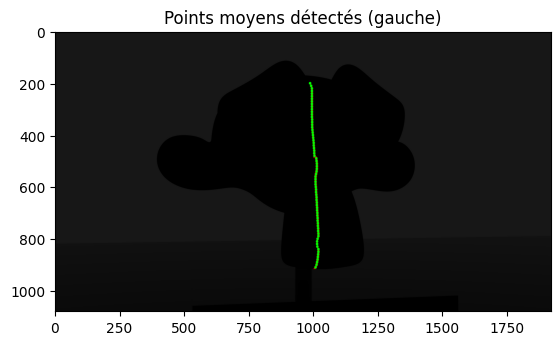

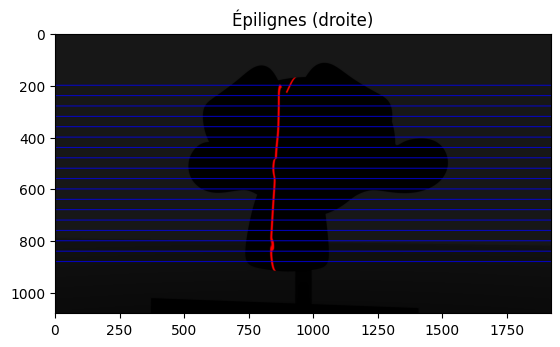

In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

# -----------------------------
# A) FONCTION crossMat(v)
# -----------------------------
def crossMat(v):
    """
    Retourne la matrice antisymétrique [v x], 
    telle que [v x] * w = v x w (produit vectoriel).
    """
    # On s'assure que v est un vecteur 3x1 (pas 4x1).
    # Par exemple, si v est 3D en forme (3,), on reshape.
    v = v.reshape(3,)
    return np.array([
        [0,     -v[2],  v[1]],
        [v[2],   0,    -v[0]],
        [-v[1],  v[0],  0   ]
    ])

# -----------------------------
# B) FONCTION matFondamental(camLeft, centerRight, camRight)
# -----------------------------
def matFondamental(camLeft, centerRight, camRight):
    """
    Calcule la matrice fondamentale F = [ (camLeft@centerRight) x ] * camLeft * pinv(camRight)
    Hypothèses:
      - camLeft et camRight sont des matrices 3x4 (projection).
      - centerRight est 4x1 (coordonnées homogènes du centre de la caméra droite
        dans le repère monde).
    """
    # 1) On projette le centre de la camRight sur la camLeft => un vecteur 3x1
    p = camLeft @ centerRight  # (3x4)*(4x1) => (3x1)

    # 2) On forme la matrice [p x] (3x3)
    px = crossMat(p)

    # 3) On multiplie px * camLeft (=> 3x3 * 3x4 = 3x4)
    tmp = px @ camLeft

    # 4) On multiplie par la pseudo-inverse de camRight (3x4)*(pinv(3x4)=>4x3 => 3x3)
    F = tmp @ np.linalg.pinv(camRight)  # => (3x3)

    return F

# -----------------------------
# C) FONCTION getImgLine(fname)
# -----------------------------
def getImgLine(fname):
    """
    Lit une image 'fname',
    on ne garde que la composante rouge (canal 2),
    on applique un seuillage pour obtenir un masque.
    Retourne le 'mask' (même taille que l'image).
    """
    img = cv.imread(fname)
    if img is None:
        raise FileNotFoundError(f"Impossible de charger l'image {fname}")
    red_channel = img[:,:,2]
    # Seuillage => tout ce qui est <127 devient 0
    # (on pourrait peaufiner)
    _, mask = cv.threshold(red_channel, 127, 255, cv.THRESH_TOZERO)
    return mask

# -----------------------------
# D) FONCTION findEpilines(path)
# -----------------------------
def findEpilines(path, nImages, Fondamental):
    """
    Cherche, pour chaque image indexée (0..nImages-1),
    la 'ligne rouge' (mask) dans l'image gauche,
    calcule la position moyenne de cette ligne en x,
    et calcule la correspondante épiligne dans l'image droite
    via la matrice fondamentale.
    Retourne une liste epilines = [
       [ pointsLeft, epilinesRight ],
       ...
    ]
    """
    epilines = []
    for i in range(nImages):
        # On reconstruit le nom du fichier : ex 0000.png, 0001.png, etc.
        if i < 10:
            strp = f"{path}000{i}.png"
        else:
            strp = f"{path}00{i}.png"

        mask = getImgLine(strp)
        h, w = mask.shape

        # On va accumuler des points (x,y,1) pour les pixels "non nuls"
        # ou leur moyenne en X par ligne Y
        pointsLeft = [[], [], []]

        for rowIndex in range(h):
            lineData = mask[rowIndex]
            # lineData est un tableau de w pixels
            # On calcule la "moyenne" des indices x où pixel != 0
            nonZeroIndices = np.where(lineData != 0)[0]  # positions x non nulles
            if len(nonZeroIndices) > 0:
                # On prend la moyenne des positions x
                meanX = np.mean(nonZeroIndices)
                pointsLeft[0].append(meanX)
                pointsLeft[1].append(rowIndex)
                pointsLeft[2].append(1)  # homogène

        # On passe en numpy
        ptsLeft_arr = np.array(pointsLeft, dtype=np.float32)  # shape (3, N)

        # epilinesRight = F * X_left  => (3x3)*(3xN) => (3xN)
        epilinesRight = Fondamental @ ptsLeft_arr

        epilines.append([ptsLeft_arr, epilinesRight])
    return epilines

# -----------------------------
# E) FONCTION drawAvgPoint et lineY
# -----------------------------
def drawAvgPoint(fname, EplLeft):
    """
    Ouvre fname, dessine les points (x,y) qu'on a dans EplLeft (3xN).
    On en prend un sur 10 par ex. pour pas surcharger.
    """
    img = cv.imread(fname)
    if img is None:
        raise FileNotFoundError(f"Impossible de charger {fname}")

    for i in range(0, EplLeft.shape[1], 10):
        x = int(EplLeft[0, i])
        y = int(EplLeft[1, i])
        color = (0,255,0)  # vert, par ex
        cv.circle(img, (x,y), 5, color, -1)

    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title("Points moyens détectés (gauche)")
    plt.show()

def lineY(a, b, c, x):
    """ Si on a la droite a*x + b*y + c=0, on renvoie y = -(c+a*x)/b. """
    return -(c + a*x)/b

def drawEpl(fname, EplRight):
    """
    Dessine (pour l'image fname) quelques épilignes en rouge.
    EplRight (3xN) => colonnes = (a,b,c) par point
       => on peut tracer la droite  a*x + b*y + c=0  sur x=[0..largeur]
    """
    img = cv.imread(fname)
    if img is None:
        raise FileNotFoundError(f"Impossible de charger {fname}")
    h, w, _ = img.shape

    # On trace 1 ligne / 40 colonnes => pas surcharger
    for i in range(0, EplRight.shape[1], 40):
        a,b,c = EplRight[:, i]
        # on fait 2 points: x=0, x=w-1
        y1 = int(lineY(a,b,c, 0))
        y2 = int(lineY(a,b,c, w-1))
        color = (255,0,0)  # rouge
        cv.line(img, (0,y1), (w-1,y2), color, 2)

    plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.title("Épilignes (droite)")
    plt.show()

# -----------------------------
# F) EXEMPLE D'UTILISATION
# -----------------------------
if __name__ == "__main__":

    # 1) On définit "camLeft" et "camRight" comme matrices 3x4.
    #    (Exemple bidon ici, à adapter selon ta projection.)
    camLeft = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0]
    ], dtype=np.float32)

    camRight = np.array([
        [1, 0, 0, -1],  # ex: translation en -X
        [0, 1, 0,  0],
        [0, 0, 1,  0]
    ], dtype=np.float32)

    # 2) Le "centre" de la camRight (en coord. homogènes 4x1),
    #    supposons qu'il est au point (1,0,0).
    #    => on met [1,0,0,1]^T
    centerRight = np.array([[1],[0],[0],[1]], dtype=np.float32)

    # 3) On calcule la matrice fondamentale
    Fondamental = matFondamental(camLeft, centerRight, camRight)

    # 4) On appelle findEpilines sur un dossier d'images "scanLeft/",
    #    on suppose qu'on a 25 images => nImages=25
    #    (à adapter !)
    nImages = 25
    epl = findEpilines("C:/Users/AbdelBadi/Desktop/final_project/scanLeft/", nImages, Fondamental)

    # 5) On teste un index i=13 pour dessiner
    i = 13
    # a) On dessine les points moyens détectés sur l'image gauche
    pathLeft = f"C:/Users/AbdelBadi/Desktop/final_project/scanLeft/00{i}.png" if i >= 10 else f"C:/Users/AbdelBadi/Desktop/final_project/scanLeft/000{i}.png"
    drawAvgPoint(pathLeft, epl[i][0])

    # b) On dessine les épilignes dans l'image droite
    pathRight= f"C:/Users/AbdelBadi/Desktop/final_project/scanRight/scan00{i}.png"
    drawEpl(pathRight, epl[i][1])


[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 0.

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 1.

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 2.

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 3.



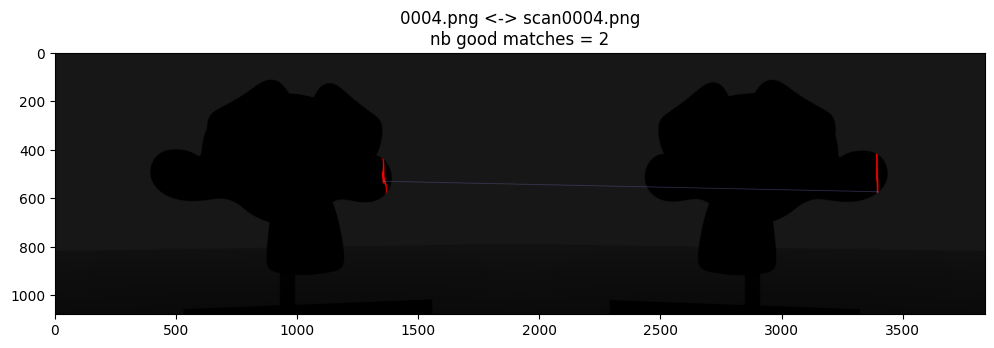

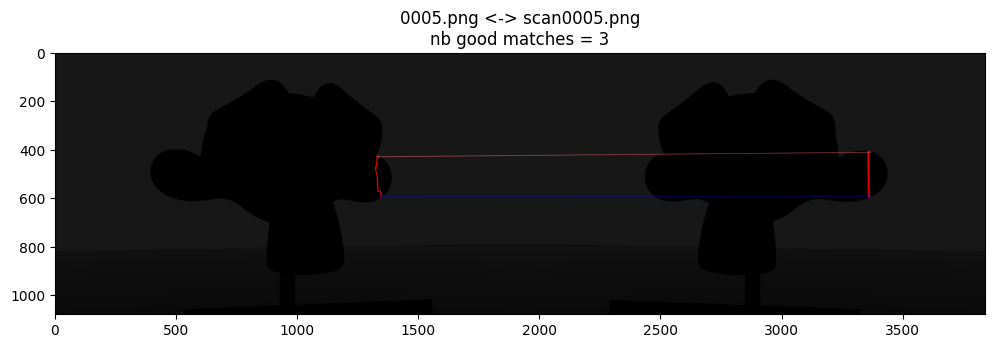

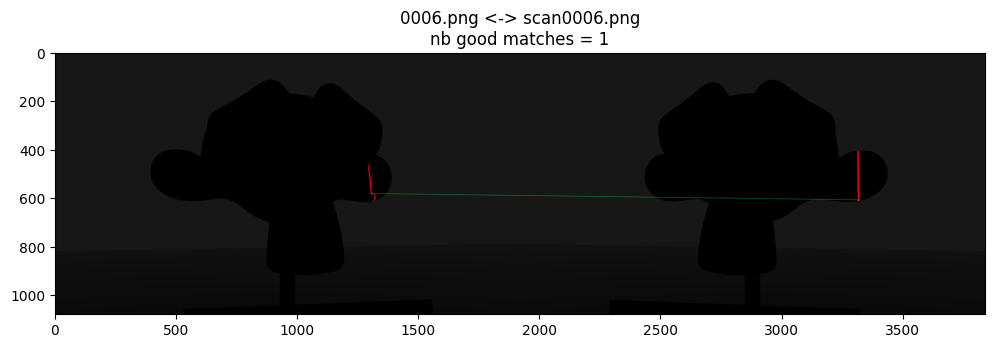

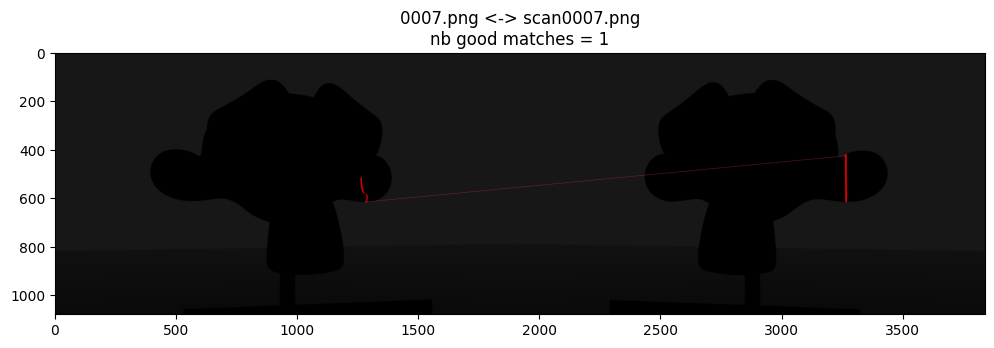

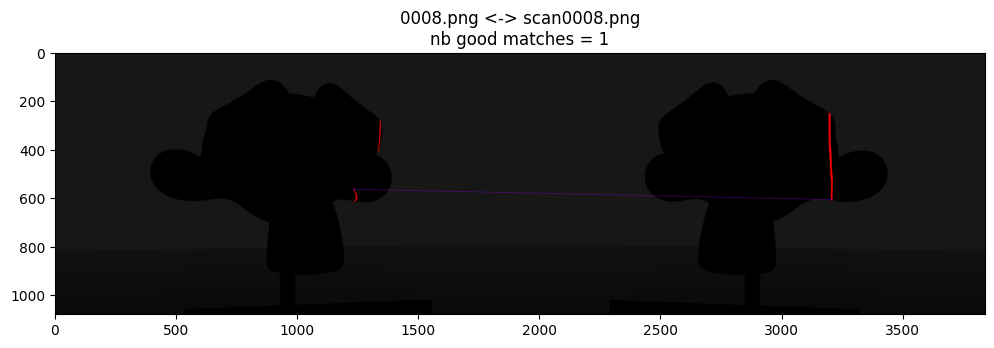

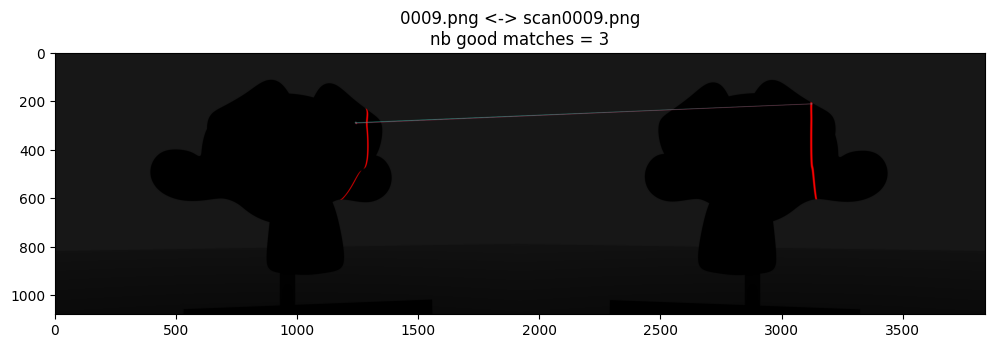

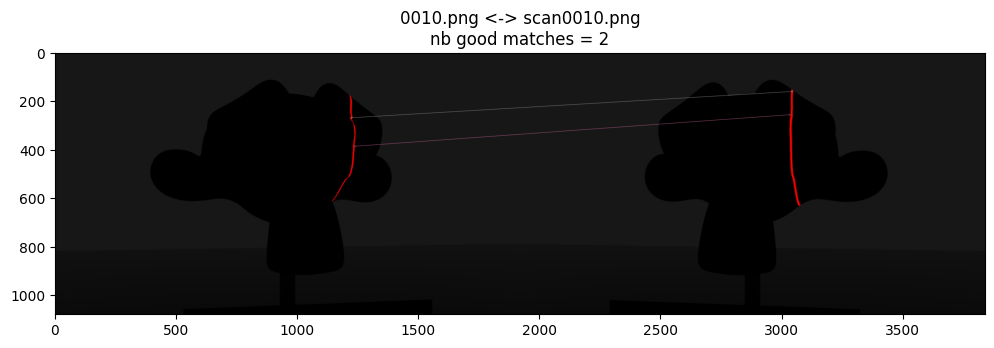

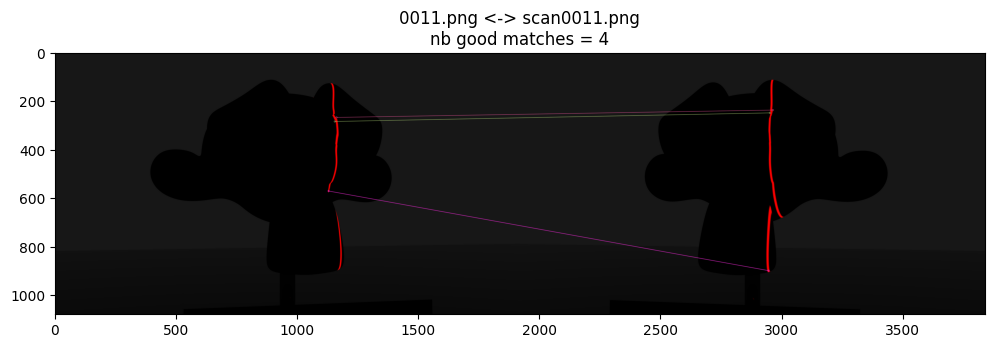

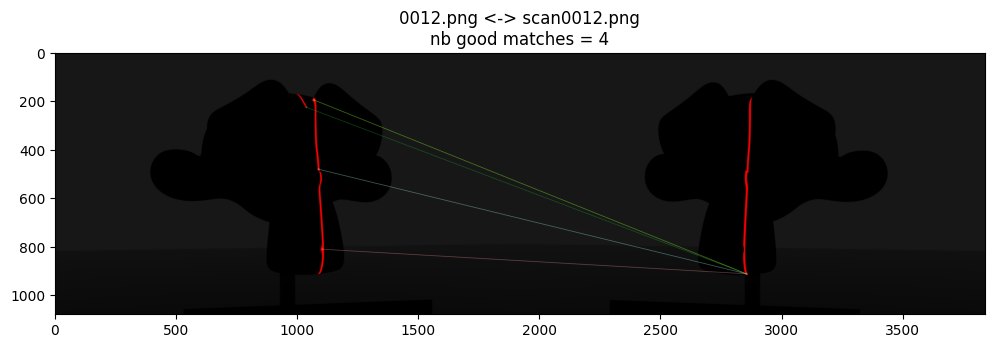

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 13.



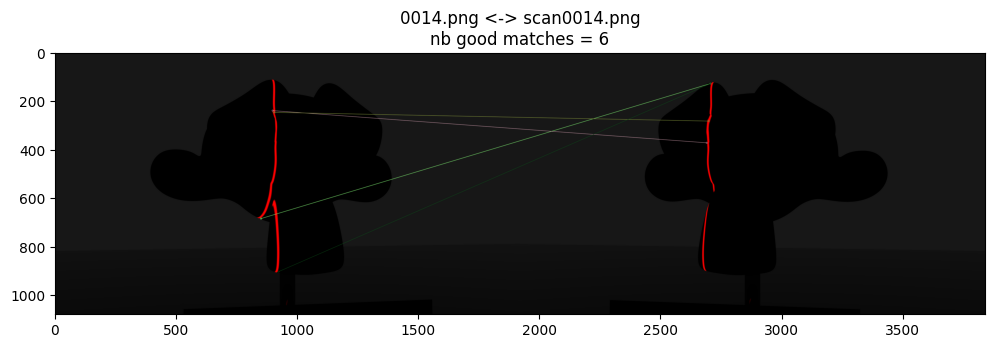

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 15.

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 16.



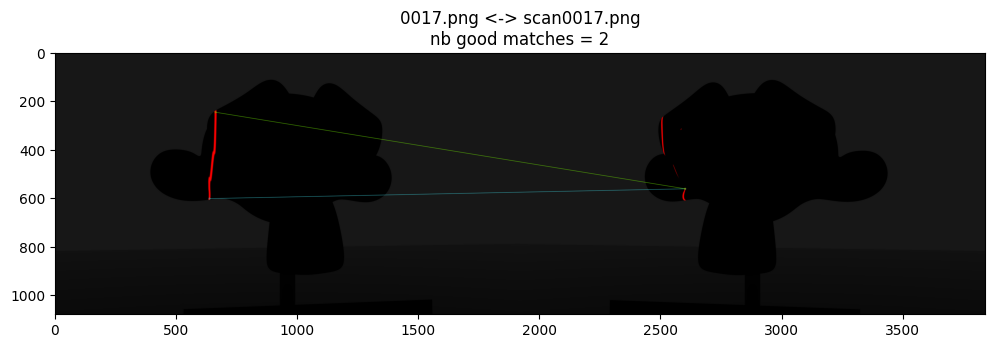

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 18.



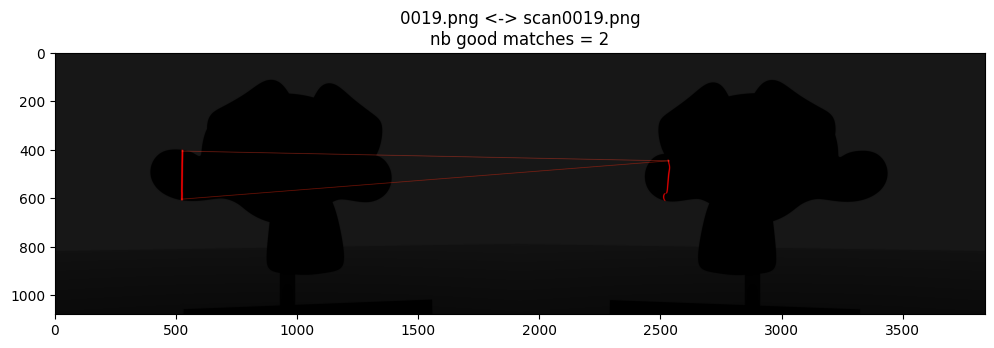

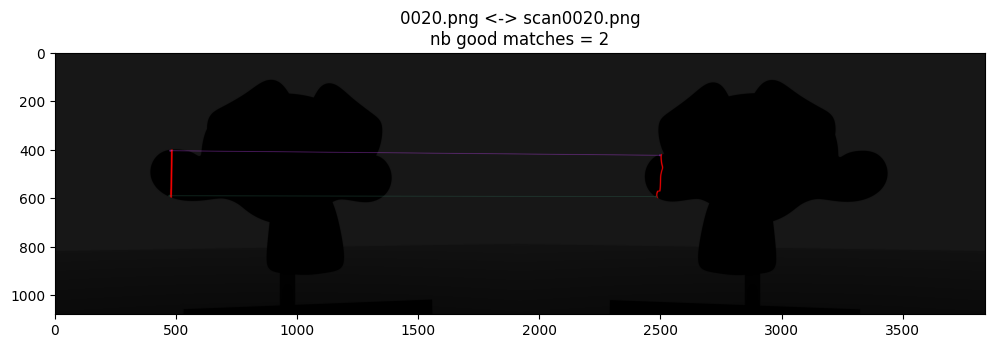

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 21.

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 22.

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 23.

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 24.

[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire 25.

Terminé.
Nombre de paires traitées = 26
Pour la première paire, nb matches conservés = 0


In [9]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

def sift_stereo_onepair(img_left_path, img_right_path, ratio_thresh=0.75):
    """
    Lit deux images (chemins donnés), détecte des keypoints SIFT,
    fait un matching BFMatcher (k=2) avec ratio test,
    et renvoie:
      - pts_left, pts_right : tableaux (N x 2) de points correspondants
      - good_matches : la liste des correspondances conservées
      - kp_left, kp_right : keypoints détectés dans chaque image
    """
    # Lecture en niveaux de gris
    img_left  = cv.imread(img_left_path,  cv.IMREAD_GRAYSCALE)
    img_right = cv.imread(img_right_path, cv.IMREAD_GRAYSCALE)
    if img_left is None or img_right is None:
        print(f"Impossible de lire {img_left_path} ou {img_right_path}")
        return None, None, [], None, None

    # Création du détecteur SIFT
    sift = cv.SIFT_create()

    # Détection et description (kp : keypoints, des : descripteurs)
    kp_left, des_left   = sift.detectAndCompute(img_left,  None)
    kp_right, des_right = sift.detectAndCompute(img_right, None)

    # BFMatcher (distance L2 par défaut), matching k=2 (ratio test)
    bf = cv.BFMatcher()
    matches_k2 = bf.knnMatch(des_left, des_right, k=2)

    good_matches = []
    for m, n in matches_k2:
        if m.distance < ratio_thresh * n.distance:
            good_matches.append(m)

    # Convertir en listes de points 2D
    pts_left  = []
    pts_right = []
    for gm in good_matches:
        pts_left.append(kp_left[gm.queryIdx].pt)
        pts_right.append(kp_right[gm.trainIdx].pt)

    pts_left  = np.array(pts_left,  dtype=np.float32)
    pts_right = np.array(pts_right, dtype=np.float32)

    return pts_left, pts_right, good_matches, kp_left, kp_right


def siftStereoAllPairs_glob(pathLeft, pathRight, patternLeft="*.png", patternRight="*.png", ratio_thresh=0.75):
    """
    1) On liste tous les fichiers *.png dans pathLeft (triés) et tous les *.png dans pathRight (triés).
    2) On associe le iᵉ fichier de left_files avec le iᵉ fichier de right_files (jusqu'au plus petit).
    3) Pour chaque couple, on fait le matching SIFT (sift_stereo_onepair).
    4) On affiche la visualisation des matches (si >0).
    5) On stocke (pts_left, pts_right) dans all_matches[i].

    Retourne all_matches, où all_matches[i] = (ptsL, ptsR).
    """
    # 1) On liste et on trie
    left_files  = sorted(glob.glob(os.path.join(pathLeft,  patternLeft)))
    right_files = sorted(glob.glob(os.path.join(pathRight, patternRight)))

    # Nombre de paires = min(len(left_files), len(right_files))
    nb_pairs = min(len(left_files), len(right_files))

    if len(left_files) != len(right_files):
        print("[Attention] Nombre de fichiers différent :")
        print(f" - Gauche : {len(left_files)} fichiers")
        print(f" - Droite : {len(right_files)} fichiers")
        print(f" => On traitera seulement {nb_pairs} paires.\n")

    all_matches = []

    for i in range(nb_pairs):
        leftF  = left_files[i]
        rightF = right_files[i]

        # 2) Matching SIFT
        ptsL, ptsR, good_matches, kpL, kpR = sift_stereo_onepair(leftF, rightF, ratio_thresh)

        if ptsL is None or ptsR is None:
            all_matches.append(([], []))
            continue

        all_matches.append((ptsL, ptsR))

        # 3) Visualisation
        imgL_color = cv.imread(leftF)
        imgR_color = cv.imread(rightF)
        if imgL_color is not None and imgR_color is not None and len(good_matches) > 0:
            matched_img = cv.drawMatches(
                imgL_color, kpL,
                imgR_color, kpR,
                good_matches, None,
                flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
            )
            plt.figure(figsize=(12,6))
            # On affiche juste le nom de fichier (basename) pour repère
            plt.title(f"{os.path.basename(leftF)} <-> {os.path.basename(rightF)}\nnb good matches = {len(good_matches)}")
            plt.imshow(cv.cvtColor(matched_img, cv.COLOR_BGR2RGB))
            plt.show()
        else:
            print(f"[Warning] Pas d'affichage (0 matches ou image non relue) pour la paire {i}.\n")

    return all_matches


if __name__ == "__main__":
    # Ex : 
    pathLeft  = r"C:\Users\AbdelBadi\Desktop\final_project\scanLeft"
    pathRight = r"C:\Users\AbdelBadi\Desktop\final_project\scanRight"

    # On liste *.png => correspond à ce que tu montres dans l'explorateur
    all_matches = siftStereoAllPairs_glob(
        pathLeft, pathRight,
        patternLeft="*.png",   # tu peux mettre *.jpg si besoin
        patternRight="*.png",  # 
        ratio_thresh=0.75
    )

    print("Terminé.")
    print(f"Nombre de paires traitées = {len(all_matches)}")

    # Ex: on regarde la taille de la 0ᵉ paire
    if len(all_matches) > 0:
        pts_left_0, pts_right_0 = all_matches[0]
        print(f"Pour la première paire, nb matches conservés = {len(pts_left_0)}")


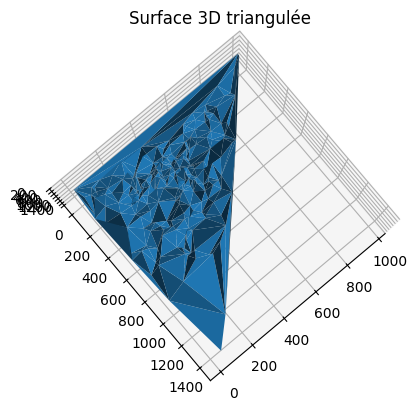

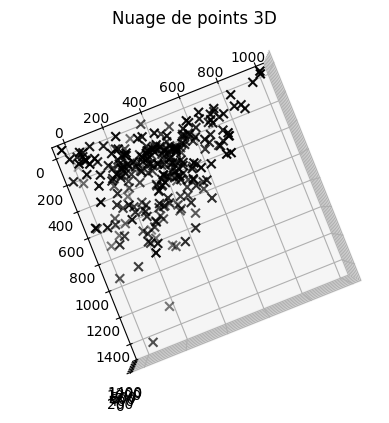

Points sauvegardés dans point.txt


In [5]:
import numpy as np
import json
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mathutils import geometry as pygeo
from mathutils import Vector

# ----------------------------------------------------------------------------
# Fonctions utilitaires
# ----------------------------------------------------------------------------

def arrayToVector(p):
    """
    Convertit un array NumPy p = [x,y,z] en Vector mathutils
    """
    return Vector((p[0], p[1], p[2]))

# ----------------------------------------------------------------------------
# getIntersection
# ----------------------------------------------------------------------------
def getIntersection(
    pointLeft,       # coord homogène 3x1 ou 4x1 ?
    pointRight,      # idem
    camLeft, 
    camRight,
    camWorldCenterLeft, 
    camWorldCenterRight
):
    """
    Calcule le point d'intersection (en 3D) des lignes provenant de :
      - la caméra gauche (camWorldCenterLeft -> pointLeft)
      - la caméra droite (camWorldCenterRight -> pointRight)
    Les lignes 3D sont calculées en utilisant la pseudo-inverse des matrices camLeft/camRight
    et en prenant comme origine les centres des caméras.
    Retourne un tuple (Vector, Vector) donné par pygeo.intersect_line_line 
    ou None si échec.
    """

    # Converti en vecteurs NumPy
    pL = np.array(pointLeft)
    pR = np.array(pointRight)

    # Projection inverse pour obtenir un point "fin" dans le repère monde
    # (Note : s'assurer que camLeft, camRight sont 3x4, et pL, pR sont 3x1 ou 4x1)
    leftObject  = np.linalg.pinv(camLeft)  @ pL
    rightObject = np.linalg.pinv(camRight) @ pR

    # Converti en Vector mathutils
    leftEndVec  = arrayToVector(leftObject[:3])   # On ne garde que x,y,z
    rightEndVec = arrayToVector(rightObject[:3])

    leftStartVec  = arrayToVector(camWorldCenterLeft)
    rightStartVec = arrayToVector(camWorldCenterRight)

    # On calcule l'intersection via mathutils.geometry
    return pygeo.intersect_line_line(leftStartVec, leftEndVec, 
                                     rightStartVec, rightEndVec)

# ----------------------------------------------------------------------------
# getObjectPoint
# ----------------------------------------------------------------------------
def getObjectPoint(
    epl,            # liste de paires [pointsLeft, epilinesRight], etc.
    pointsRight,    # liste de points 3D (dans l'image de droite), shape = 26 x ...
    camLeft, 
    camRight,
    camWorldCenterLeft, 
    camWorldCenterRight,
    scale=1000.0,
    nImages=26
):
    """
    Pour chaque image l dans [0..nImages-1], on récupère :
      - epl[l][0] = pointsLeft (3xN) ou (4xN)
      - pointsRight[l] = (3xN) ou (4xN)
    On appelle getIntersection(...) pour chaque colonne i
    On stocke le point d'intersection final dans point[].
    Retourne point sous forme np.array([ [x..],[y..],[z..] ]).
    """

    # On prépare les listes pour x, y, z
    point = [[], [], []]  # (x, y, z)

    for l in range(nImages):
        # 1) Récupère pointsLeft, pointsRight sur lᵉ image
        if l >= len(epl):
            break
        pointsLeft = np.array(epl[l][0])   # shape(3,N) ou shape(4,N)
        if l >= len(pointsRight):
            break
        ptsRight   = np.array(pointsRight[l])  # shape(3,N)

        # 2) On itère sur chaque colonne i
        nb_cols = min(pointsLeft.shape[1], ptsRight.shape[1])

        for i in range(nb_cols):
            # Intersection 3D
            try:
                inter = getIntersection(
                    pointsLeft[:, i],
                    ptsRight[:, i],
                    camLeft,
                    camRight,
                    camWorldCenterLeft,
                    camWorldCenterRight
                )
                # intersect_line_line retourne (Vector, Vector).
                # Souvent c'est (pointCam1, pointCam2). En pratique, ce sont
                # 2 points proches l'un de l'autre si tout va bien.
                # On peut prendre la moyenne ou le 1er.

                if inter is not None:
                    pA, pB = inter
                    # On prend pA ou la moyenne
                    p = (pA + pB) / 2.0

                    # scale, si besoin (ex. pour passer en mm)
                    x, y, z = p.x * scale, p.y * scale, p.z * scale
                    point[0].append(x)
                    point[1].append(y)
                    point[2].append(z)
            except:
                pass

    return np.array(point)

# ----------------------------------------------------------------------------
# Visualisation des points : drawPointObject
# ----------------------------------------------------------------------------
def drawPointObject(point3D):
    """
    Affiche un nuage de points (point3D) sous forme np.array([ [x..],[y..],[z..] ]) en 3D.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter3D(point3D[0,:], point3D[1,:], point3D[2,:],
                 s=40, c='black', marker='x')

    ax.view_init(elev=-90, azim=-70)
    plt.title("Nuage de points 3D")
    plt.show()

# ----------------------------------------------------------------------------
# Visualisation de la surface : drawSurfaceObject
# ----------------------------------------------------------------------------
def drawSurfaceObject(point3D):
    """
    Dessine une surface 3D via plot_trisurf.
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot_trisurf(point3D[0,:], point3D[1,:], point3D[2,:])
    ax.view_init(elev=-95, azim=-50)
    plt.title("Surface 3D triangulée")
    plt.show()

# ----------------------------------------------------------------------------
# Sauvegarde JSON : pointToJson
# ----------------------------------------------------------------------------
def pointToJson(point3D, outname="point.txt"):
    """
    Sauvegarde les points x,y,z dans un fichier JSON.
    """
    data = {
        'x': point3D[0,:].tolist(),
        'y': point3D[1,:].tolist(),
        'z': point3D[2,:].tolist()
    }
    with open(outname,'w') as f:
        json.dump(data, f)
    print(f"Points sauvegardés dans {outname}")

# ----------------------------------------------------------------------------
# Exemple d'utilisation
# ----------------------------------------------------------------------------
if __name__ == "__main__":
    # 0) Définir (ou charger) les matrices de projection et centres caméras
    #    => Adapte ces variables selon ton cas.
    camLeft = np.array([  # 3x4
        [1,0,0,0],
        [0,1,0,0],
        [0,0,1,0]
    ], dtype=float)

    camRight= np.array([  # 3x4
        [1,0,0,-1],
        [0,1,0, 0],
        [0,0,1, 0]
    ], dtype=float)

    camWorldCenterLeft  = np.array([0,0,0])  # (x,y,z)
    camWorldCenterRight = np.array([1,0,0])  # (x,y,z)

    # 1) epl = liste de 26 éléments, epl[l] = [ pointsLeft(3,N), epilinesRight(3,N) ]
    #    On suppose tu as déjà calculé epl ou tu le charges.  
    #    ICI on simule => on fait epl[i][0] = 3x10
    epl = []
    for i in range(26):
        pointsLeftSim = np.random.rand(3, 10)
        epl.append([pointsLeftSim, None])  # Juste pour l'exemple

    # 2) pointsRight = liste de 26 éléments, pointsRight[l] = 3xN
    #    On simule pareil
    pointsRight = []
    for i in range(26):
        ptsRSim = np.random.rand(3, 10)
        pointsRight.append(ptsRSim)

    # 3) On calcule le nuage de points 3D
    point3D = getObjectPoint(
        epl=epl,
        pointsRight=pointsRight,
        camLeft=camLeft,
        camRight=camRight,
        camWorldCenterLeft=camWorldCenterLeft,
        camWorldCenterRight=camWorldCenterRight,
        scale=1000.0,
        nImages=26
    )

    # 4) Affichage
    drawSurfaceObject(point3D)
    drawPointObject(point3D)

    # 5) Sauvegarde JSON
    pointToJson(point3D, "point.txt")


In [6]:
import json
# Charger les données JSON depuis le fichier
with open('point.txt', 'r') as file:
    data = json.load(file)
# Afficher les données
#print("Coordonnées en X :", data['x'])
#print("Coordonnées en Y :", data['y'])
#print("Coordonnées en Z :", data['z'])

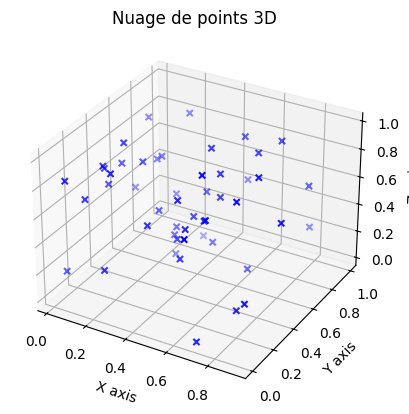

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def plot3DPoints(point):
    """
    Affiche un nuage de points 3D donné par un array de forme (3, N).
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.scatter(point[0, :], point[1, :], point[2, :], c='b', marker='x')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')

    plt.title("Nuage de points 3D")
    plt.show()

if __name__ == "__main__":
    #
    point = np.random.rand(3, 50)  # 3 lignes (x,y,z), 50 colonnes (points)

    # On appelle la fonction pour l'afficher
    plot3DPoints(point)
